In [78]:
from typing import List

import polars as pl
import hvplot
import sklearn
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [18]:
sklearn.set_config(transform_output="polars")

# Utility Functions

In [64]:

def create_features(dataframe:pl.DataFrame) -> pl.DataFrame:
    """
    Create time series features based on time series index.
    """
    return (
       dataframe
        .with_columns(
            pl.col("Datetime").dt.hour().alias("hour"),
           pl.col("Datetime").dt.weekday().alias("dayofweek"),
           pl.col("Datetime").dt.quarter().alias("quarter"),
           pl.col("Datetime").dt.month().alias("month"),
           pl.col("Datetime").dt.year().alias("year"),
           pl.col("Datetime").dt.ordinal_day().alias("dayofyear"),
           pl.col("Datetime").dt.day().alias("dayofmonth"),
           pl.col("Datetime").dt.week().alias("weekofyear"),
           
        )
)

### Dataset

In [20]:
dataset: pl.DataFrame = pl.read_csv(
    "~/Developer/xgboostProject/data/01_raw/PJME_hourly.csv"
)

In [21]:
print(dataset)

shape: (145_366, 2)
┌─────────────────────┬─────────┐
│ Datetime            ┆ PJME_MW │
│ ---                 ┆ ---     │
│ str                 ┆ f64     │
╞═════════════════════╪═════════╡
│ 2002-12-31 01:00:00 ┆ 26498.0 │
│ 2002-12-31 02:00:00 ┆ 25147.0 │
│ 2002-12-31 03:00:00 ┆ 24574.0 │
│ 2002-12-31 04:00:00 ┆ 24393.0 │
│ 2002-12-31 05:00:00 ┆ 24860.0 │
│ …                   ┆ …       │
│ 2018-01-01 20:00:00 ┆ 44284.0 │
│ 2018-01-01 21:00:00 ┆ 43751.0 │
│ 2018-01-01 22:00:00 ┆ 42402.0 │
│ 2018-01-01 23:00:00 ┆ 40164.0 │
│ 2018-01-02 00:00:00 ┆ 38608.0 │
└─────────────────────┴─────────┘


In [22]:
df: pl.DataFrame = dataset.select(
    pl.col("Datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"),
    pl.col("PJME_MW").cast(pl.Float32),
)

:Curve   [Datetime]   (PJME_MW)
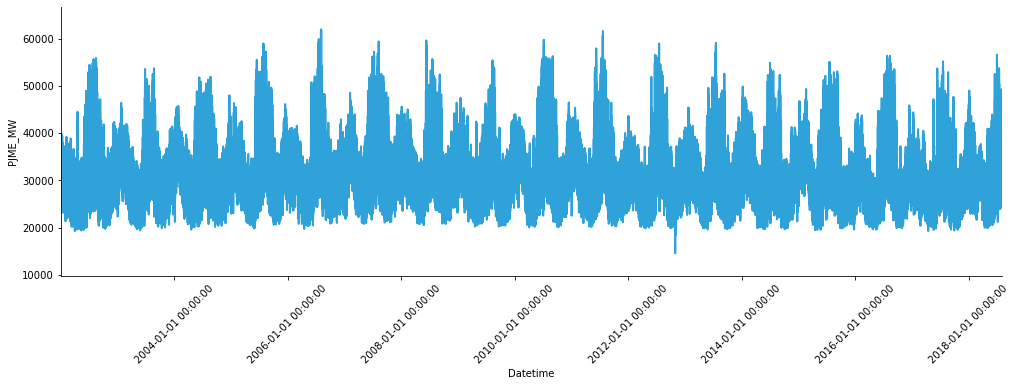

In [24]:
df.plot(x="Datetime", y="PJME_MW", width=1400, height=400, rot=45, fontsize=10, xlabel="Datetime", ylabel="PJME_MW")

# TRAIN / TEST SPLIT

In [25]:
train: pl.DataFrame = df.filter(pl.col("Datetime") < pl.datetime(2015, 1, 1))
test: pl.DataFrame = df.filter(pl.col("Datetime") >= pl.datetime(2015, 1, 1))

In [26]:
print(train)

shape: (113_926, 2)
┌─────────────────────┬─────────┐
│ Datetime            ┆ PJME_MW │
│ ---                 ┆ ---     │
│ datetime[μs]        ┆ f32     │
╞═════════════════════╪═════════╡
│ 2002-12-31 01:00:00 ┆ 26498.0 │
│ 2002-12-31 02:00:00 ┆ 25147.0 │
│ 2002-12-31 03:00:00 ┆ 24574.0 │
│ 2002-12-31 04:00:00 ┆ 24393.0 │
│ 2002-12-31 05:00:00 ┆ 24860.0 │
│ …                   ┆ …       │
│ 2014-01-01 20:00:00 ┆ 36193.0 │
│ 2014-01-01 21:00:00 ┆ 35601.0 │
│ 2014-01-01 22:00:00 ┆ 34242.0 │
│ 2014-01-01 23:00:00 ┆ 32215.0 │
│ 2014-01-02 00:00:00 ┆ 30159.0 │
└─────────────────────┴─────────┘


:NdOverlay   [Variable]
   :Curve   [Datetime]   (value)
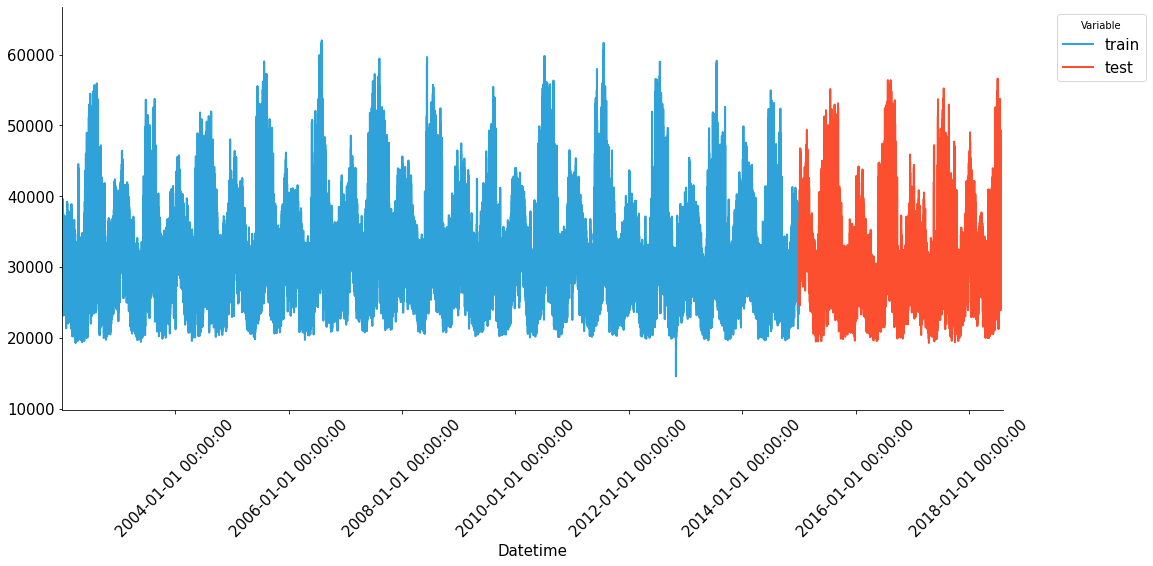

In [40]:
(
    train.with_columns(source=pl.lit("train"))
    .vstack(test.with_columns(source=pl.lit("test")))
    .pivot(
        columns=["source"],
        index="Datetime",
        values="PJME_MW",
        aggregate_function="mean",
    )
    .plot(
        width=1400,
        height=600,
        x="Datetime",
        rot=45,
        fontscale=1.5
    )
)

:Curve   [Datetime]   (PJME_MW)
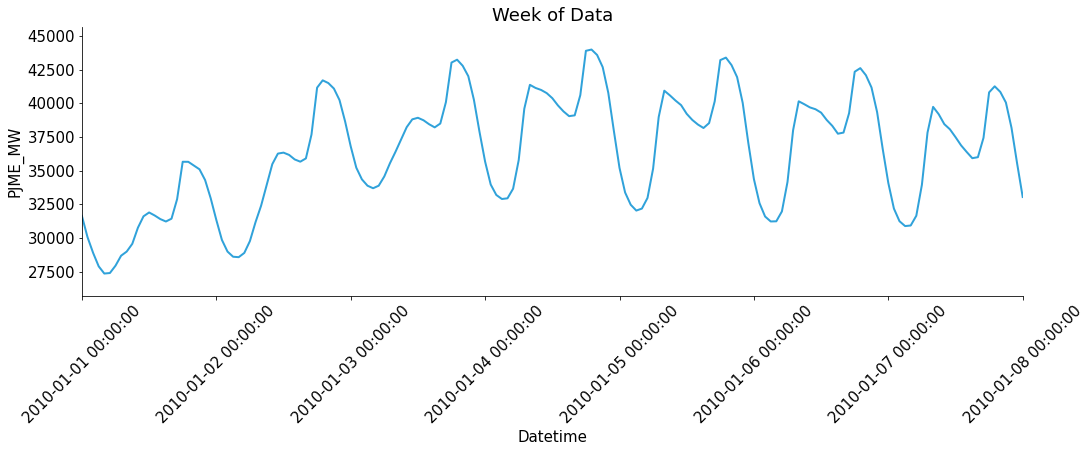

In [39]:
(
    df.filter(
        pl.col("Datetime").is_between(pl.datetime(2010, 1, 1), pl.datetime(2010, 1, 8))
    )
    .plot(x="Datetime", y="PJME_MW", width=1400, height=400, title="Week of Data", fontscale=1.5, rot=45)
)

# FEATURE ENGINEERING

In [30]:
dataframe : pl.DataFrame = create_features(df)

In [31]:
print(dataframe)

shape: (145_366, 10)
┌──────────────┬─────────┬──────┬───────────┬───┬──────┬───────────┬────────────┬────────────┐
│ Datetime     ┆ PJME_MW ┆ hour ┆ dayokweek ┆ … ┆ year ┆ dayofyear ┆ dayofmonth ┆ weekofyear │
│ ---          ┆ ---     ┆ ---  ┆ ---       ┆   ┆ ---  ┆ ---       ┆ ---        ┆ ---        │
│ datetime[μs] ┆ f32     ┆ i8   ┆ i8        ┆   ┆ i32  ┆ i16       ┆ i8         ┆ i8         │
╞══════════════╪═════════╪══════╪═══════════╪═══╪══════╪═══════════╪════════════╪════════════╡
│ 2002-12-31   ┆ 26498.0 ┆ 1    ┆ 2         ┆ … ┆ 2002 ┆ 365       ┆ 31         ┆ 1          │
│ 01:00:00     ┆         ┆      ┆           ┆   ┆      ┆           ┆            ┆            │
│ 2002-12-31   ┆ 25147.0 ┆ 2    ┆ 2         ┆ … ┆ 2002 ┆ 365       ┆ 31         ┆ 1          │
│ 02:00:00     ┆         ┆      ┆           ┆   ┆      ┆           ┆            ┆            │
│ 2002-12-31   ┆ 24574.0 ┆ 3    ┆ 2         ┆ … ┆ 2002 ┆ 365       ┆ 31         ┆ 1          │
│ 03:00:00     ┆         ┆   

# Visualize our features / target relationship

:BoxWhisker   [hour]   (PJME_MW)
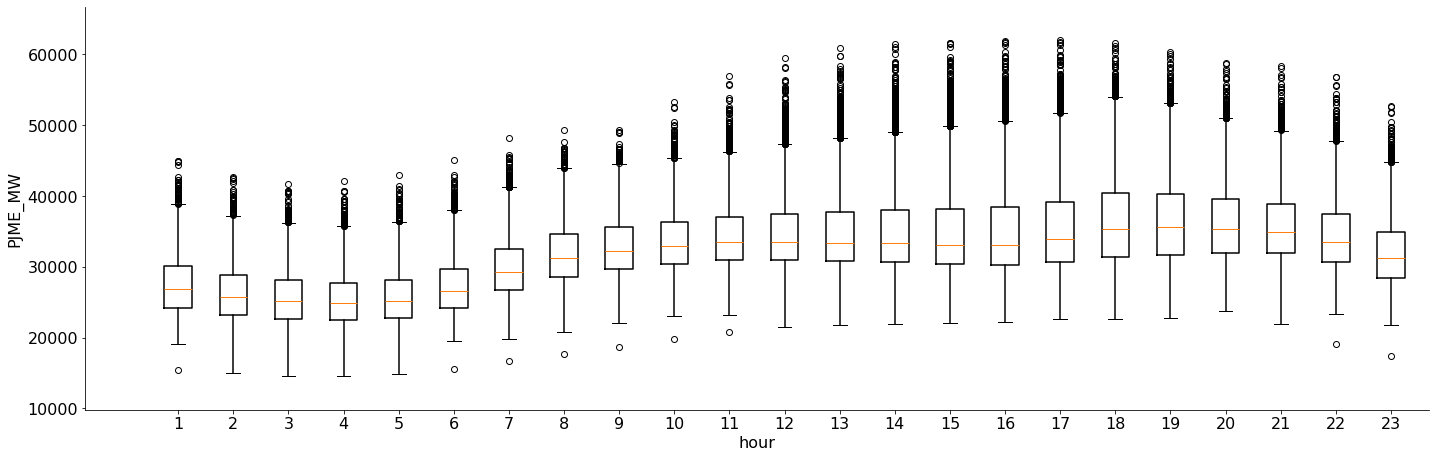

In [37]:
(
    dataframe
    .plot.box(y="PJME_MW", by="hour", width=2000, height=600, fontscale=1.6, colorbar=True)
)

:BoxWhisker   [month]   (PJME_MW)
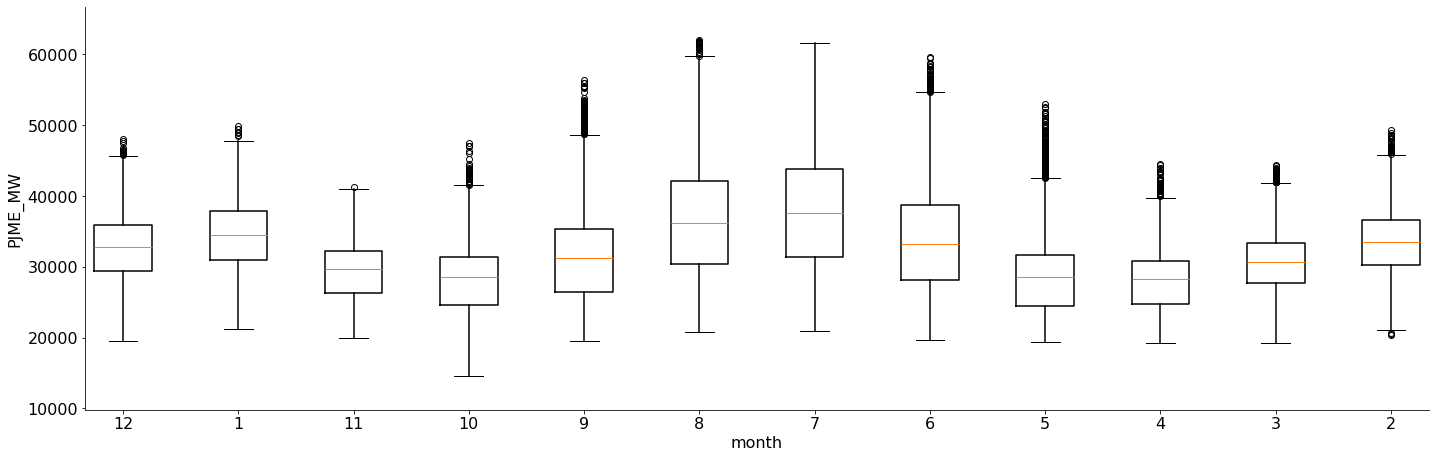

In [59]:
(
    dataframe
    .plot.box(y="PJME_MW", by="month", width=2000, height=600, fontscale=1.6, colorbar=True)      
)

# Create Model

In [125]:
train: pl.DataFrame = create_features(train)
test: pl.DataFrame = create_features(test)

FEATURES: List[str] = ["dayofyear", "hour", "dayofweek", "quarter", "month", "year"]
TARGET: str = "PJME_MW"

X_train: pl.DataFrame = train.select(FEATURES)
y_train: pl.DataFrame = train.select(TARGET)

X_test: pl.DataFrame = test.select(FEATURES)
y_test: pl.DataFrame = test.select(TARGET)


In [134]:
print(X_train)

shape: (113_926, 6)
┌───────────┬──────┬───────────┬─────────┬───────┬──────┐
│ dayofyear ┆ hour ┆ dayofweek ┆ quarter ┆ month ┆ year │
│ ---       ┆ ---  ┆ ---       ┆ ---     ┆ ---   ┆ ---  │
│ i16       ┆ i8   ┆ i8        ┆ i8      ┆ i8    ┆ i32  │
╞═══════════╪══════╪═══════════╪═════════╪═══════╪══════╡
│ 365       ┆ 1    ┆ 2         ┆ 4       ┆ 12    ┆ 2002 │
│ 365       ┆ 2    ┆ 2         ┆ 4       ┆ 12    ┆ 2002 │
│ 365       ┆ 3    ┆ 2         ┆ 4       ┆ 12    ┆ 2002 │
│ 365       ┆ 4    ┆ 2         ┆ 4       ┆ 12    ┆ 2002 │
│ 365       ┆ 5    ┆ 2         ┆ 4       ┆ 12    ┆ 2002 │
│ …         ┆ …    ┆ …         ┆ …       ┆ …     ┆ …    │
│ 1         ┆ 20   ┆ 3         ┆ 1       ┆ 1     ┆ 2014 │
│ 1         ┆ 21   ┆ 3         ┆ 1       ┆ 1     ┆ 2014 │
│ 1         ┆ 22   ┆ 3         ┆ 1       ┆ 1     ┆ 2014 │
│ 1         ┆ 23   ┆ 3         ┆ 1       ┆ 1     ┆ 2014 │
│ 2         ┆ 0    ┆ 4         ┆ 1       ┆ 1     ┆ 2014 │
└───────────┴──────┴───────────┴─────────┴───────┴──

In [127]:
reg: XGBRegressor =XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000,
             early_stopping_rounds=50, objective="reg:squarederror",
             max_depth=3, learning_rate=0.01)

In [128]:
reg

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [129]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21569	validation_1-rmse:11743.75114
[200]	validation_0-rmse:5835.12466	validation_1-rmse:5365.67709
[300]	validation_0-rmse:3915.75557	validation_1-rmse:4020.67023
[400]	validation_0-rmse:3443.16468	validation_1-rmse:3853.40423
[500]	validation_0-rmse:3285.33804	validation_1-rmse:3805.30176
[600]	validation_0-rmse:3201.92936	validation_1-rmse:3772.44933
[700]	validation_0-rmse:3148.14225	validation_1-rmse:3750.91108
[800]	validation_0-rmse:3109.24248	validation_1-rmse:3733.89713
[900]	validation_0-rmse:3079.40079	validation_1-rmse:3725.61224
[999]	validation_0-rmse:3052.73503	validation_1-rmse:3722.92257


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Feature Importance

In [143]:
fi: pl.DataFrame = pl.DataFrame(
    {
        "feature": FEATURES,
        "importance": reg.feature_importances_
    }
)

:Bars   [feature]   (importance)
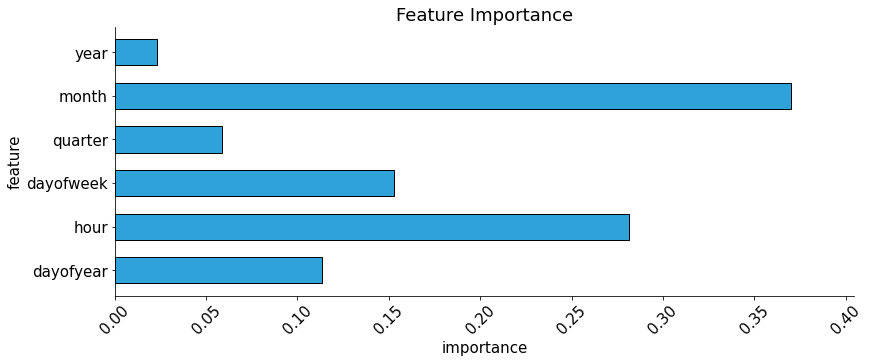

In [154]:
(
    fi
    .plot.barh(x="feature", y="importance", width=1100, height=400,
               title="Feature Importance", fontscale=1.5, rot=45)
)